<a href="https://colab.research.google.com/github/ShivaniGawande/DLFinalProject_Fall22/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, SpatialDropout1D
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer
!pip install tokenizers
!pip install transformers
from tokenizers import BertWordPieceTokenizer
import torch
import transformers
from transformers import TFBertModel


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
#loading data from google drive
'''
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''

#train_file_id = '15NNft0C1CKlKDzjUKbAgibbXTFe8NFgG'
#test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 
'''
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
train_data  = pd.read_csv("train.csv")
train_data.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
df = pd.read_json(url, lines=True)
print(df.head())
     

     label                                           response  \
0  SARCASM  @USER @USER @USER I don't get this .. obviousl...   
1  SARCASM  @USER @USER trying to protest about . Talking ...   
2  SARCASM  @USER @USER @USER He makes an insane about of ...   
3  SARCASM  @USER @USER Meanwhile Trump won't even release...   
4  SARCASM  @USER @USER Pretty Sure the Anti-Lincoln Crowd...   

                                             context  
0  [A minor child deserves privacy and should be ...  
1  [@USER @USER Why is he a loser ? He's just a P...  
2  [Donald J . Trump is guilty as charged . The e...  
3  [Jamie Raskin tanked Doug Collins . Collins lo...  
4  [Man ... y ’ all gone “ both sides ” the apoca...  


In [39]:
df.isna().sum() # Checking for NaN values

label       0
response    0
context     0
dtype: int64

In [40]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


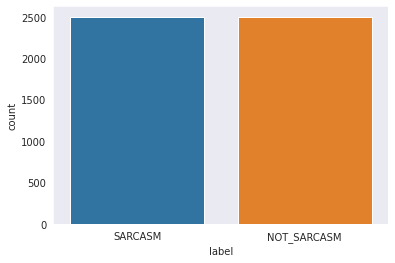

In [41]:
sns.set_style("dark")
sns.countplot(df.label)

In [60]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [71]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['response']=df['response'].apply(denoise_text)

In [85]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = []

for indx, item in enumerate(df.context.values):
  corpus+= get_corpus([df.response[indx]])
  for i in range(0, len(item)):
      corpus+= get_corpus([item[i]])

corpus[:3]

['get', 'obviously', 'care']

In [86]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'@USER': 28324,
 '.': 24671,
 'the': 14806,
 ',': 14365,
 'to': 11811,
 'a': 8853,
 'of': 7748,
 'and': 7651,
 'I': 7318,
 'you': 6553}

In [133]:
label_mapping = {'SARCASM': 1, 'NOT_SARCASM': 0}
df.label = df.label.map(label_mapping)

In [134]:
#X = df[['response','context']]
X= df.response
y = df['label']
y

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: label, Length: 5000, dtype: int64

In [135]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)

In [136]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [137]:
def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids


In [138]:
train_ids = encoder(X_train.values)
test_ids = encoder(X_test.values)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [139]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(y_test)
train_labels = tf.convert_to_tensor(y_train)

In [140]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output) 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [141]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_bert_model_1 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             16, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [143]:
num_epochs = 30
history = model.fit(x = train_ids, y = train_labels, epochs = num_epochs, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/30
118/118 [==============================] - 18s 150ms/step - loss: 0.3700 - accuracy: 0.8379 - val_loss: 0.5795 - val_accuracy: 0.7472
Epoch 2/30
118/118 [==============================] - 17s 146ms/step - loss: 0.2432 - accuracy: 0.9032 - val_loss: 0.6927 - val_accuracy: 0.7472
Epoch 3/30
118/118 [==============================] - 17s 147ms/step - loss: 0.1489 - accuracy: 0.9461 - val_loss: 0.8363 - val_accuracy: 0.7440
Epoch 4/30
118/118 [==============================] - 18s 153ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 1.0277 - val_accuracy: 0.7376
Epoch 5/30
118/118 [==============================] - 17s 148ms/step - loss: 0.0716 - accuracy: 0.9747 - val_loss: 1.0873 - val_accuracy: 0.7416
Epoch 6/30
118/118 [==============================] - 17s 148ms/step - loss: 0.0579 - accuracy: 0.9808 - val_loss: 1.1647 - val_accuracy: 0.7336
Epoch 7/30
118/118 [==============================] - 17s 148ms/step - loss: 0.0408 - accuracy: 0.9861 - val_loss: 1.2115 - val_ac

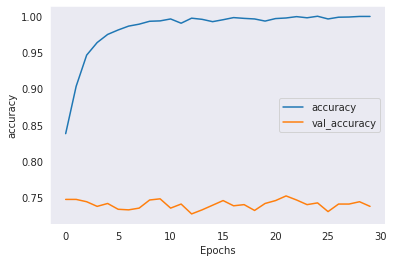

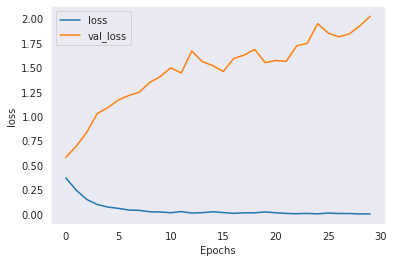

In [144]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [145]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_ids,test_labels)[1]*100 , "%")

40/40 [==============================] - 4s 89ms/step - loss: 2.0213 - accuracy: 0.7376
Accuracy of the model on Testing Data is -  73.7600028514862 %


In [147]:
pred = model.predict(test_ids)
pred = np.round(pred).astype(int)
pred[:5]

40/40 [==============================] - 3s 65ms/step


array([[1],
       [0],
       [0],
       [0],
       [0]])

In [148]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       625
           1       0.74      0.74      0.74       625

    accuracy                           0.74      1250
   macro avg       0.74      0.74      0.74      1250
weighted avg       0.74      0.74      0.74      1250



In [149]:
cm = confusion_matrix(y_test,pred)
cm

array([[459, 166],
       [162, 463]])

Text(69.0, 0.5, 'Actual')

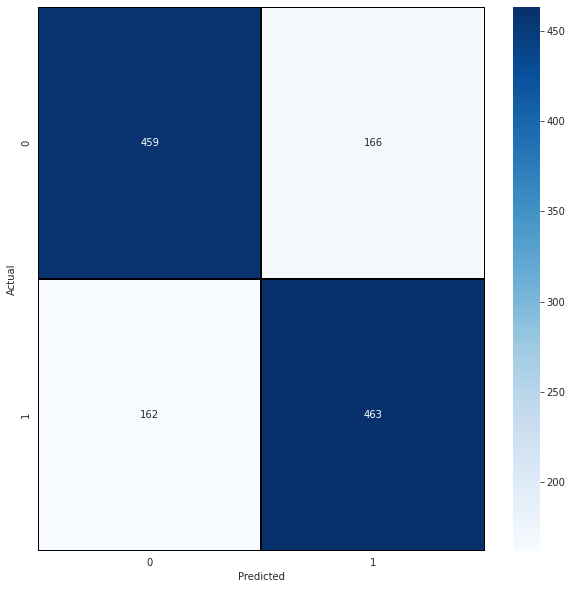

In [150]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")